In [1]:
import numpy as np
import pinocchio as pin
from example_robot_data import load
from scipy.optimize import linprog
from scipy.spatial import ConvexHull

In [2]:
#loading go2 model
robot = load("go2")

In [3]:
#loading visualiser
from utils.meshcat_viewer_wrapper import MeshcatVisualizer # the meshcat visualiser
viz = MeshcatVisualizer(robot)
viz.display(robot.q0)
print(robot.model)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/
Nb joints = 14 (nq=19,nv=18)
  Joint 0 universe: parent=0
  Joint 1 root_joint: parent=0
  Joint 2 FL_hip_joint: parent=1
  Joint 3 FL_thigh_joint: parent=2
  Joint 4 FL_calf_joint: parent=3
  Joint 5 FR_hip_joint: parent=1
  Joint 6 FR_thigh_joint: parent=5
  Joint 7 FR_calf_joint: parent=6
  Joint 8 RL_hip_joint: parent=1
  Joint 9 RL_thigh_joint: parent=8
  Joint 10 RL_calf_joint: parent=9
  Joint 11 RR_hip_joint: parent=1
  Joint 12 RR_thigh_joint: parent=11
  Joint 13 RR_calf_joint: parent=12



In [14]:
#defining effector frames

viz.display(robot.q0)
pin.forwardKinematics(robot.model, robot.data, robot.q0)
pin.updateFramePlacements(robot.model, robot.data)
pin.updateGeometryPlacements(robot.model, robot.data, robot.collision_model, robot.collision_data)

effectors = ["FL_foot_joint", "RL_foot_joint", "RR_foot_joint", "FR_foot_joint"]
frame_ids = [robot.model.getFrameId(eff) for eff in effectors]
placements = [robot.data.oMf[frame_id] for frame_id in frame_ids]

#display effectors positions just to make sure that there is no offset
effectorspheres_id = ['world/ball'+eff for eff in effectors]
[viz.addSphere(sph_id,.023,[1,0,0,1]) for sph_id in effectorspheres_id]

for frame_id, sph_id in zip(frame_ids, effectorspheres_id):
    pos = robot.data.oMf[frame_id].translation
    viz.applyConfiguration(sph_id,[pos[0],pos[1],pos[2],1,0,0,0])


In [15]:
NUM_SAMPLES = 50
IT_DISPLAY_PROGRESS = NUM_SAMPLES / 10
MIN_DIST_BETWEEN_FEET_Y = 0.10
MIN_DIST_BETWEEN_FEET_X = 0.10
MAX_DIST_BETWEEN_FEET_X = 0.35
MAX_DIST_BETWEEN_FEET_Z = 0.35
MIN_HEIGHT_COM = 0.3
# margin used to constrain the com y position : if it's on the left of the left foot
# or on the right of the right foot
# for more than this margin, we reject this sample:
MARGIN_FEET_SIDE = 0.02
ZERO_CONF = robot.q0[:7]

In [16]:
#define a function that generates a random configuration that is acceptable, ie
# collision free, with the trunk above the feet, no cross over, and somehow in quasi static equilibrium

#applies a configuration and updates geometry and data
def apply(q):    
    pin.forwardKinematics(robot.model, robot.data, q)
    pin.updateFramePlacements(robot.model, robot.data)
    pin.updateGeometryPlacements(robot.model, robot.data, robot.collision_model, robot.collision_data)

# all functions below assume apply has been called
def collision():
    return pin.computeCollisions(robot.collision_model,robot.collision_data,True)
    
def feet_below_base_ok(positions):
    """
    returns true if the configuration is in quasi-static equilibrium assuming quasi-flat surfaces
    """
    return all( [pos[2] < ZERO_CONF[2]-0.1 for pos in positions])
    
def no_crossing(positions):
    """
    returns true if legs do not cross
    """
    #order is effectors = ["FL_foot_joint", "RL_foot_joint", "RR_foot_joint", "FR_foot_joint"]
    # first, front legs before back legs
    if positions[0][0] <  positions[1][0] or positions[2][0] >  positions[3][0]:
        return False
    # then left leg more to the right than right leg
    if positions[0][1] <  positions[3][1] or positions[1][1] <  positions[2][1]:
        return False
    return True
    

    
def stay_on_side(positions):
    """
    returns true if legs stay on their "side"
    """
    #order is effectors = ["FL_foot_joint", "RL_foot_joint", "RR_foot_joint", "FR_foot_joint"]
    # first, front legs before back legs
    if positions[0][1] <  MARGIN_FEET_SIDE or positions[1][1]  <  MARGIN_FEET_SIDE:
        return False
    # then left leg more to the right than right leg
    if positions[2][1] >  -MARGIN_FEET_SIDE or positions[3][1]  >  -MARGIN_FEET_SIDE:
        return False
    return True
    
def static_eq(positions, com):    
    """
    returns true if the configuration is in quasi-static equilibrium assuming quasi-flat surfaces
    """
    return True;
    sizeX = len(positions)
    E = np.zeros((3, sizeX))
    for i, pos in enumerate(positions):
        E[:2, i] = pos[:2]
    e = np.array([com[0], com[1], 1.0])
    E[2, :] = np.ones(sizeX)
    res = linprog(
        np.ones(sizeX),
        A_ub=None,
        b_ub=None,
        A_eq=E,
        b_eq=e,
        bounds=[(0.0, 1.0) for _ in range(sizeX)],
        method="interior-point",
        callback=None,
        options={"presolve": True},
    )
    return res["success"]



def point_not_inside_hull(positions):
    """
    returns False of one of the point is inside the convex hulls of the others.
    We do not want that, or do we?
    """
    for i, pos in enumerate(positions):
        others = positions[:i] + positions[i + 1 :]
        if staticEq(others, pos):
            return False
    return True

def gen_quasi_static():
    while True:
        q = pin.randomConfiguration(robot.model)
        q[:7]= ZERO_CONF[:]
        apply(q)    
        positions = [robot.data.oMf[frame_id].translation.tolist() for frame_id in frame_ids]
        com = pin.centerOfMass(robot.model, robot.data, q)
        if not collision() and stay_on_side(positions) and no_crossing(positions) and feet_below_base_ok(positions) and static_eq(positions, com):
            return q, positions, com
    

q, _,_  = gen_quasi_static()
viz.display(q)
for frame_id, sph_id in zip(frame_ids, effectorspheres_id):
    pos = robot.data.oMf[frame_id].translation
    viz.applyConfiguration(sph_id,[pos[0],pos[1],pos[2],1,0,0,0])

In [17]:
#storing com points and other effectors points
compoints = [[] for _ in effectors]
points = [{} for _ in effectors]
for i, eff in enumerate(effectors):
    for j, otherEff in enumerate(effectors):
        if i != j:
            points[i][otherEff] = []
            

In [18]:
def printFootPositionRelativeToOther(q_s, pos_s, com_s):
    global compoints, points 
    nbConfigs = len(q_s)
    for i, (positions, com) in enumerate(zip( pos_s, com_s)):
        if i > 0 and not i % IT_DISPLAY_PROGRESS:
            print(int((i * 100) / nbConfigs), " % done")
        for j, (effectorName, pos) in enumerate(zip(effectors, positions)):
            for otheridx, (oeffectorName, pos_other) in enumerate(zip(effectors, positions)):
                if otheridx != j:         
                    p = (np.array(pos_other[:3])) - (np.array(pos[:3]).tolist())
                    points[j][oeffectorName].append(p[:3])
            compoints[j].append(com.tolist())


In [19]:
#generate configurations
def generate_configurations():
    q_p_coms = [gen_quasi_static() for _ in range (NUM_SAMPLES)]
    print(el[1] for el in q_p_coms)
    return [el[0] for el in q_p_coms],[el[1] for el in q_p_coms],[el[2] for el in q_p_coms]

q_s, pos_s, com_s = generate_configurations()
printFootPositionRelativeToOther(q_s, pos_s, com_s)

<generator object generate_configurations.<locals>.<genexpr> at 0x7dc34880e4d0>
10  % done
20  % done
30  % done
40  % done
50  % done
60  % done
70  % done
80  % done
90  % done


ax is none
ax is none


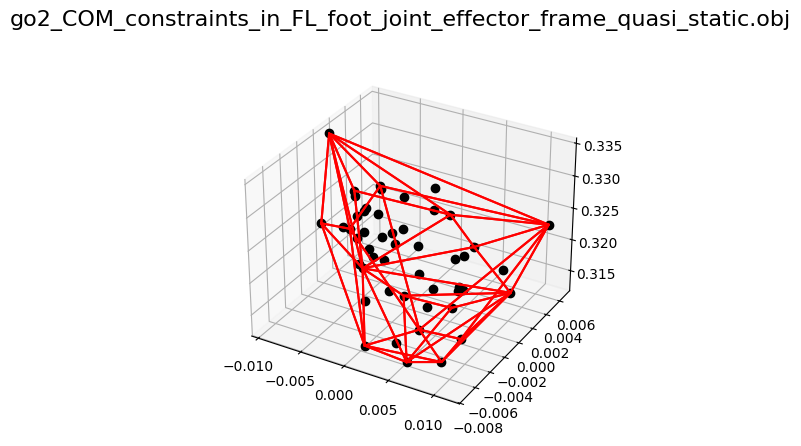

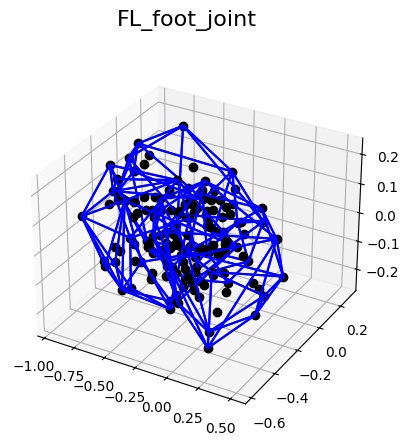

ax is none
ax is none


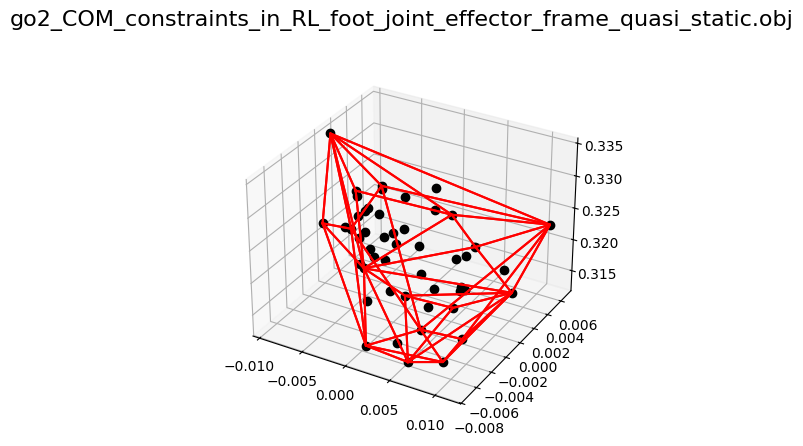

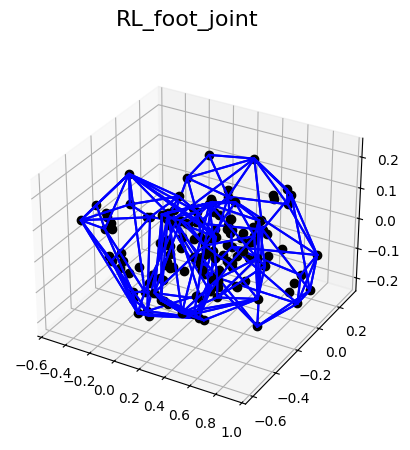

ax is none
ax is none


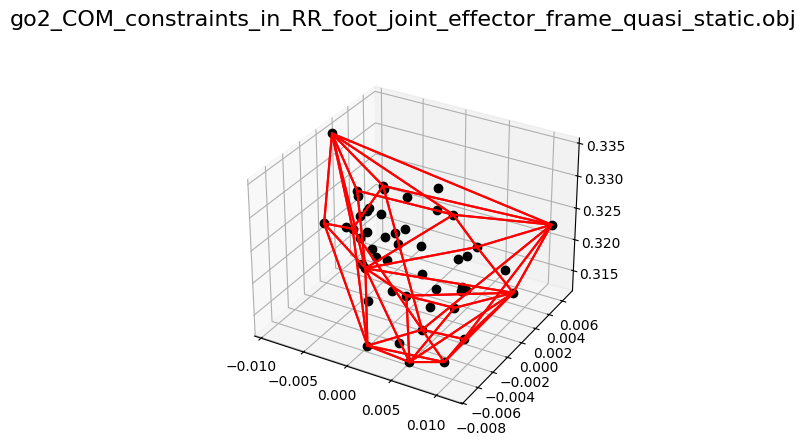

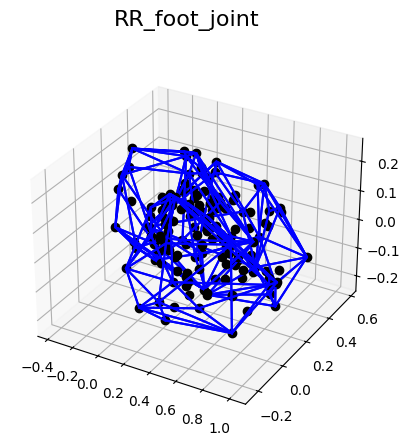

ax is none
ax is none


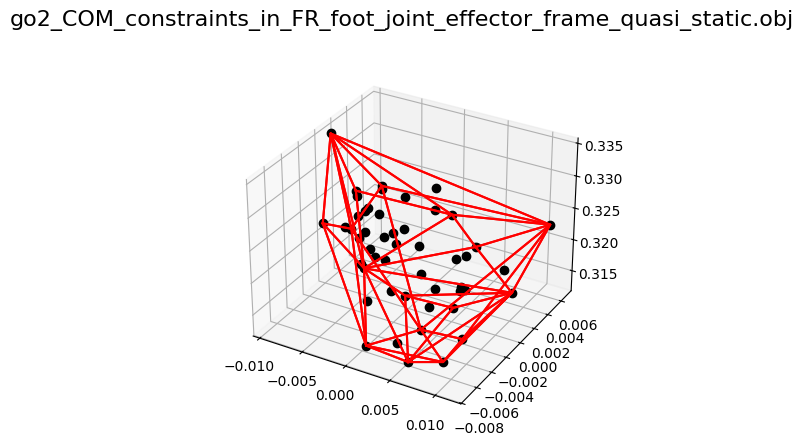

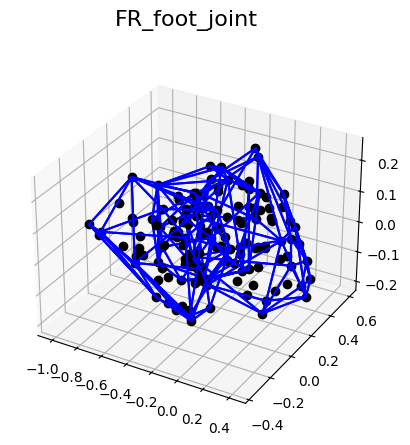

In [21]:
#now generate polytopes
from constants_and_tools import hull_to_obj
from plot_polytopes import plot_hull
import matplotlib.pyplot as plt

for effector, comData, pointsData in zip(effectors, compoints, points):
    hcom = ConvexHull(comData)
    hull_to_obj(
        hcom,
        comData,
        "go2_COM_constraints_in_" + str(effector) + "_effector_frame_quasi_static.obj",
    )
    fig = plt.figure()
    fig.suptitle(
        "go2_COM_constraints_in_" + str(effector) + "_effector_frame_quasi_static.obj",
        fontsize=16,
    )
    plot_hull(hcom, comData, np.array(comData), color="r", plot=False, fig=fig, ax=None)

    fig = plt.figure()
    fig.suptitle(str(effector), fontsize=16)
    # ~ axes = [221,222,223,224]
    ax = None
    # ~ for (oEffector, pts), axId in zip(pointsData.items(), axes):
    for oEffector, pts in pointsData.items():
        # ~ ax = fig.add_subplot(axId, projection="3d")
        hpts = ConvexHull(pts)
        hull_to_obj(
            hpts,
            pts,
            "go2_" + str(oEffector) + "_constraints_in_" + str(effector) + ".obj",
        )
        ax = plot_hull(hpts, pts, np.array(pts), color="b", plot=False, fig=fig, ax=ax)
    plt.show(block=False)